In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# Path to the folder containing CSV files
folder_path = "/content/drive/MyDrive/csv"

# Check if the folder exists
if os.path.exists(folder_path):
    # List to hold all dataframes
    dfs = []

    # Iterate over each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            # Read each CSV file and append its dataframe to the list
            df = pd.read_csv(os.path.join(folder_path, file_name))
            dfs.append(df)

    # Check if any CSV files were found
    if len(dfs) > 0:
        # Concatenate all dataframes into one
        combined_df = pd.concat(dfs, ignore_index=True)




In [ ]:
combined_df

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0.0,Drake,God’s Plan,Scorpion,2018.0,2018-01-19,and they wishin' and wishin' and wishin' and w...
1,1.0,Drake,In My Feelings,Scorpion,2018.0,2018-06-29,drake trap trapmoneybenny this shit got me in ...
2,2.0,Drake,Hotline Bling,Views,2015.0,2015-07-25,you used to call me on my you used to you used...
3,3.0,Drake,One Dance,Views,2016.0,2016-04-05,kyla baby i like your style drake grips on y...
4,4.0,Drake,"Hold On, We’re Going Home",Nothing Was the Same,2013.0,2013-08-07,produced by nineteen85 majid jordan noah 40 s...
...,...,...,...,...,...,...,...
6022,474.0,Taylor Swift,Teardrops on my Guitar (Live from Clear Channe...,Live From Clear Channel Stripped 2008,2008.0,2008-06-28,drew looks at me i fake a smile so he won't se...
6023,475.0,Taylor Swift,Evermore [Forward],NaN,2020.0,2020-12-11,to put it plainly we just couldnt stop writing...
6024,476.0,Taylor Swift,Welcome Back Grunwald,NaN,NaN,NaN,turn wycd on you're on your grunwald back from...
6025,477.0,Taylor Swift,Tolerate it (Polskie Tłumaczenie),NaN,2020.0,2020-12-11,zwrotka siedzę i patrzę jak czytasz z głową p...


In [ ]:
df_new = combined_df[['Artist', 'Title', 'Lyric']].copy()

In [ ]:
df_new["Lyric"][12]

"produced by mike zombie   started zombie on the track   started from the bottom now we're here started from the bottom now my whole team fuckin' here started from the bottom now we're here started from the bottom now the whole team here nigga started from the bottom now we're here started from the bottom now my whole team here nigga started from the bottom now we're here started from the bottom now the whole team fuckin' here   i done kept it real from the jump livin' at my momma's house we'd argue every month nigga i was tryna get it on my own workin' all night traffic on the way home and my uncle callin' me like where you at i gave you the keys told you bring it right back nigga i just think it's funny how it goes now i'm on the road half a million for a show and we   started from the bottom now we're here started from the bottom now my whole team fuckin' here started from the bottom now we're here started from the bottom now the whole team here nigga started from the bottom now we'

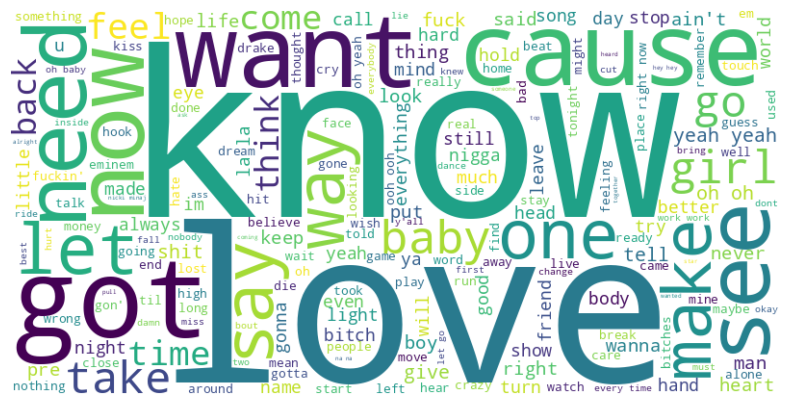

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Concatenate lyrics from DataFrame column into a single text string
lyrics_text = ' '.join(str(lyrics) for lyrics in df_new['Lyric'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics_text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec

song_df = df_new
song_df = song_df[(song_df["Lyric"].str.len() <= 3500) & (song_df["Lyric"].str.len() >= 400)]

# Remove duplicates
song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)

# Train Word2Vec model
lyrics_corpus = [lyric.split() for lyric in song_df['Lyric']]
word2vec_model = Word2Vec(sentences=lyrics_corpus, vector_size=100, window=5, min_count=1, workers=4)

def get_recommendations(input_lyrics, song_dataframe, word2vec_model):
    input_lyrics_tokens = input_lyrics.split()
    input_lyrics_vectors = [word2vec_model.wv[word] for word in input_lyrics_tokens if word in word2vec_model.wv.key_to_index]
    input_lyrics_vector = sum(input_lyrics_vectors) / len(input_lyrics_vectors) if input_lyrics_vectors else None

    similarities = []
    for idx, row in song_dataframe.iterrows():
        song_lyrics_tokens = row['Lyric'].split()
        song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
        song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None

        if input_lyrics_vector is not None and song_lyrics_vector is not None:
            similarity = word2vec_model.wv.cosine_similarities(input_lyrics_vector, [song_lyrics_vector])[0]
            similarities.append(similarity)
        else:
            similarities.append(0)  # Assign 0 similarity if one of the vectors is None

    song_dataframe['Similarity'] = similarities
    recommended_songs = song_dataframe.sort_values(by='Similarity', ascending=False).head(5)

    return recommended_songs[['Artist', 'Title', 'Similarity']]

# Example Usage
input_songs = "they wishin' and wishin"
recommended_songs = get_recommendations(input_songs, df_new, word2vec_model)
print(recommended_songs)

<ipython-input-104-ad1ce5458155>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)


AttributeError: 'float' object has no attribute 'split'

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string

# Load the dataset and perform initial filtering
song_df = df_new
song_df = song_df[(song_df["Lyric"].str.len() <= 3500) & (song_df["Lyric"].str.len() >= 400)]

# Remove duplicates
song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)

## Remove stop words and clean lyrics
stop_words = set(stopwords.words('english'))

# Custom stopwords specific to song lyrics
custom_stop_words = {
    'oh', 'ah', 'yeah', 'baby', 'na', 'la', 'da', 'woo', 'hey',
    'gonna', 'wanna', 'gotta', 'ain', 'em', 'gon', 'wan', 'gimme',
    'im', 'ive', 'youre', 'dont', 'cant', 'wont', 'isnt', 'wasnt', 'hes', 'shes',
    'couldnt', 'wouldnt', 'shouldnt', 'aint', 'gimme', 'gimme', 'gotcha', 'gon', 'wanna',
    'gotta', 'aint', 'imma', 'imma', 'imma', 'ima', 'imma', 'uh', 'uhh', 'uhhh', 'mmm',
    'mmmh', 'hmm', 'hmmh', 'mmmm', 'mmmmh', 'na', 'nah', 'yeah', 'yeh', 'yay', 'uhuh',
    'uh-uh', 'uhhuh', 'oh', 'ooh', 'oohh', 'ah', 'ahh', 'ahhh', 'huh', 'huhh', 'huhhh',
    'hey', 'heyy', 'heyyy', 'oh', 'ah', 'woah', 'whoa', 'la', 'lala', 'lalala', 'lalala',
    'da', 'dadada', 'dada', 'dadaa', 'dadaaa', 'dum', 'dumdum', 'dummm', 'dummm', 'dummmm'
}

# Combine NLTK stopwords and custom stopwords
all_stop_words = stop_words.union(custom_stop_words)

punctuation = set(string.punctuation)

def clean_lyrics(lyric):
    # Convert text to lowercase
    lyric = lyric.lower()
    # Remove punctuation
    lyric = ''.join(char for char in lyric if char not in punctuation)
    # Remove stopwords
    lyric = ' '.join(word for word in lyric.split() if word not in all_stop_words)
    return lyric

song_df['Cleaned_Lyric'] = song_df['Lyric'].apply(clean_lyrics)

<ipython-input-105-eb7bb73d074e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df.drop_duplicates(subset=["Artist", "Title"], inplace=True)
<ipython-input-105-eb7bb73d074e>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df['Cleaned_Lyric'] = song_df['Lyric'].apply(clean_lyrics)


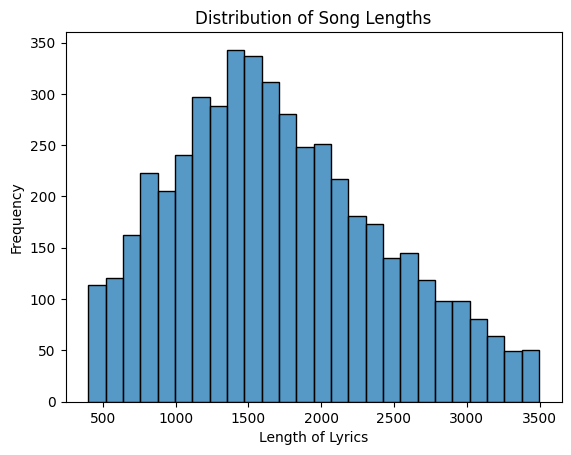

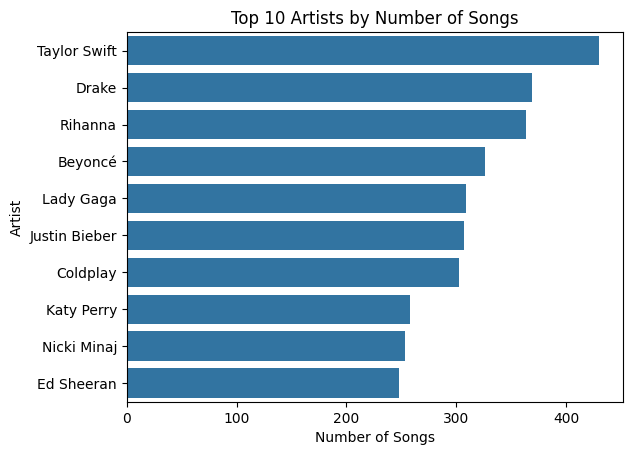

In [ ]:
# Exploratory Data Analysis (EDA)
# Visualize the distribution of song lengths
sns.histplot(song_df['Lyric'].str.len())
plt.xlabel('Length of Lyrics')
plt.ylabel('Frequency')
plt.title('Distribution of Song Lengths')
plt.show()

# Visualize the distribution of artists
sns.countplot(y='Artist', data=song_df, order=song_df['Artist'].value_counts().index[:10])
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.title('Top 10 Artists by Number of Songs')
plt.show()

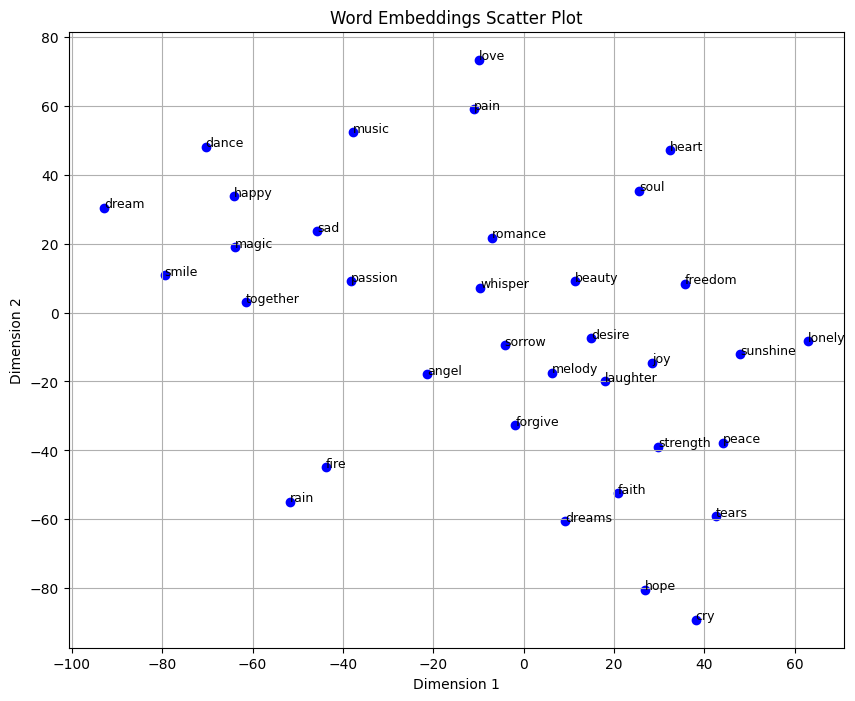

In [ ]:
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words_of_interest = ['love', 'music', 'happy', 'sad', 'dance', 'heart', 'joy', 'cry', 'smile', 'passion',
                     'melody', 'sorrow', 'romance', 'hope', 'dream', 'peace', 'pain', 'soul', 'desire',
                     'together', 'lonely', 'forgive', 'faith', 'magic', 'sunshine', 'rain', 'angel',
                     'fire', 'dreams', 'whisper', 'laughter', 'tears', 'strength', 'beauty', 'freedom']  # Choose words from your dataset
word_embeddings = [word2vec_model.wv[word] for word in words_of_interest]
word_embeddings = np.array(word_embeddings)
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=4, random_state=42)  # Adjust perplexity as needed
word_embeddings_2d = tsne.fit_transform(word_embeddings)


# Plot the scatter plot
plt.figure(figsize=(10, 8))
for i, word in enumerate(words_of_interest):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='blue')
    plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=9)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

In [ ]:
# Train Word2Vec model
lyrics_corpus = [lyric.split() for lyric in song_df['Cleaned_Lyric']]
word2vec_model = Word2Vec(sentences=lyrics_corpus, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def get_recommendations(input_lyrics, song_dataframe, word2vec_model):
    input_lyrics_tokens = input_lyrics.split()
    input_lyrics_vector = sum([word2vec_model.wv[word] for word in input_lyrics_tokens if word in word2vec_model.wv.key_to_index]) / len(input_lyrics_tokens)

    similarities = []
    for idx, row in song_dataframe.iterrows():
        if isinstance(row['Lyric'], str):  # Check if 'Lyric' is a string
            song_lyrics_tokens = row['Lyric'].split()
            song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
            song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None
            if song_lyrics_vector is not None:
                similarity = np.dot(input_lyrics_vector, song_lyrics_vector) / (np.linalg.norm(input_lyrics_vector) * np.linalg.norm(song_lyrics_vector))
                similarities.append((row['Title'], similarity))
        else:
            # Convert non-string values to strings before proceeding
            lyric_str = str(row['Lyric'])
            song_lyrics_tokens = lyric_str.split()
            song_lyrics_vectors = [word2vec_model.wv[word] for word in song_lyrics_tokens if word in word2vec_model.wv.key_to_index]
            song_lyrics_vector = sum(song_lyrics_vectors) / len(song_lyrics_vectors) if song_lyrics_vectors else None
            if song_lyrics_vector is not None:
                similarity = np.dot(input_lyrics_vector, song_lyrics_vector) / (np.linalg.norm(input_lyrics_vector) * np.linalg.norm(song_lyrics_vector))
                similarities.append((row['Title'], similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities


In [ ]:
# Example Usage
input_songs = "night changes"
recommended_songs = get_recommendations(input_songs, df_new, word2vec_model)
print(recommended_songs)

[('Goodnight Gotham', 0.9873827), ('Marry the Night (Zedd Remix)', 0.9640152), ('Marry the Night - The Weeknd & Illangelo Remix', 0.95463467), ('Marry the Night', 0.94744045), ('My Life', 0.9225549), ('Last Friday Night (T.G.I.F.)', 0.90777445), ('Spoil My Night', 0.90420806), ('Last Friday Night (T.G.I.F.) [Remix]', 0.8881181), ('Silent Night', 0.885716), ('Silent Night', 0.8747112), ('Lost In Your Light', 0.8667757), ('Earth to Move', 0.86113125), ('Spend The Night', 0.8547676), ('America', 0.8427629), ('Cece’s Interlude', 0.8413828), ('Save the Day', 0.84033525), ('Everynight', 0.8380667), ('Up All Night', 0.83701783), ('Cemeteries of London', 0.835863), ('Frankensteined (Fanmade Edit)', 0.8351818), ('Give Me That', 0.83382094), ('Slow Down (Jason Nevins Remix)', 0.83078545), ('Levitating (KUU Remix)', 0.8264316), ('Slow Down (Chew Fu Refix)', 0.82413524), ('THE STARS', 0.8188435), ('Dancing in the Dark', 0.81842786), ('Slow Down', 0.81835914), ('Slow Down (Smash Mode Remix)', 0.817

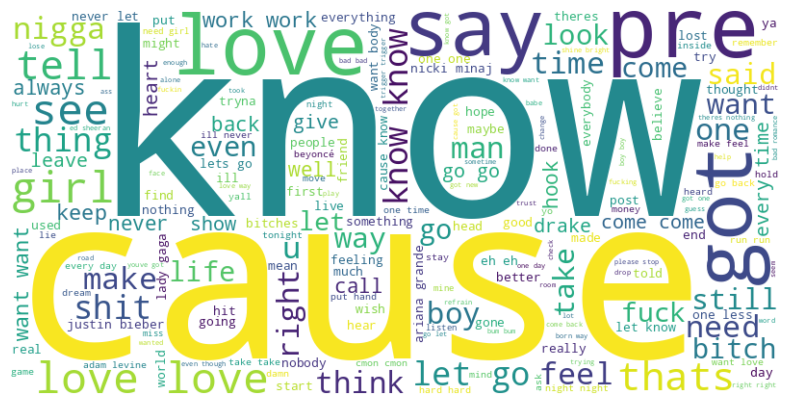

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Concatenate lyrics from DataFrame column into a single text string
lyrics_text = ' '.join(str(lyrics) for lyrics in song_df['Cleaned_Lyric'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics_text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
